# End-to-End ML (Part 2): Data Cleaning and Feature Engineering

This is the second part of the series of tutorials on data wrangling. In the first part we started the process of data wrangling on the Titanic dataset, focusing on the EDA aspects. Recall that the point of doing EDA first was to give us a feel of the data. How big the data is; how many samples; how many features; problematic problems like missing values, duplicate samples, and useless features; etc. To see the results of our EDA on the Titatic dataset see that previous tutorial.

In this next part we'll focus on data cleaning and feature engineering. The goal of data cleaning is to take the messy raw data we have and transform it into quality data that an ML model can train on. The goal of feature engineering is to identify which raw features from the raw data might be useful, and where feasible create potentially useful new derived features from them.

We'll continue on with the example Titanic dataset from before. Since the plan is to do data cleaning, feature engineering, and (finally) train a working model, I'll go ahead and load numpy, pandas, matplotlib, and various sklearn and imblearn functions we covered before for imbalanced classification. I'll also specify a seed since randomness will be used in this code, and finally port over a useful function I've used in prior tutorials for printing out various metrics during model training.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

seed = 123
np.random.seed(seed)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_scores(y,yhat):
    print('accuracy: ', round(accuracy_score(y, yhat), 4))
    print('precision: ', round(precision_score(y, yhat), 4))
    print('recall: ', round(recall_score(y, yhat), 4))
    print('f1: ', round(f1_score(y, yhat), 4))
    print('auc: ', round(roc_auc_score(y, yhat), 4))
    print('confusion matrix:\n', confusion_matrix(y, yhat))

## Data Cleaning and Feature Engineering: First Pass

Focusing on the Titanic dataset again, I'll again import the data from the URL below, verify that the output is what was expected, and drop the `PassengerId` column since EDA identified it as a useless feature (a duplicate index). Recall that the ultimate goal here is to build a model that can predict whether a passenger of the Titanic survived, given the other features present in this dataset.

This time when loading the dataframe I'll call it `df_raw`, and then make a copy of it into the dataframe `df` that we'll clean up. This is a good idea to do because it's easy to screw something up when data cleaning, and so if you do it's worth having the raw data around to go back to and try again.

In [4]:
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df_raw = pd.read_csv(url)
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df = df_raw.copy()

In [7]:
df = df.drop(columns='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now, let's start by cleaning up the non-string columns since they're the easiest to deal with. Going in left-to-right order, we first have the `Survived` column, which will end up being the labels for the ML problem. From the EDA, we know that there are no missing values here, and that the values are already encoded as binary integers with `0 = not survived` and `1 = survived`. That means this column is already good and we can move on.

The next column is `Pclass`. Recall that `Pclass` takes on the integer values `1, 2, 3`. It has no missing values. And it is evidently a categorical variable representing what boarding class the passenger was in. The fact that `Pclass` is categorical means that there is no (far as we can tell) no natural ordering. With categorical data, it wouldn't make sense to say `1 < 2 < 3`. It would make about as much sense as saying `red < blue < orange`. We thus may want to encode this data differently, e.g. one-hot encodings or embeddings. I'll ignore this for now and come back to it later. Other than this issue, this column appears good to go as well.

The next non-string column is `Sex`. Recall that this column (as the name implies) represents passenger sex, and is encoded as `male`, `female`. This feature is obviously categorical. There are no missing values in this column. To deal with the encodings, I'll for now map `0 = male` and `1 = female`, though we may want to use a different categorical encoding later.

In [8]:
df['Sex'] = df['Sex'].replace(to_replace='male', value=0)
df['Sex'] = df['Sex'].replace(to_replace='female', value=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


Next is the `Age` column. Recall this is a numerical feature with ages ranging roughly 0-80 years in not-necessarily-integer values (some passengers gave their age in years and months evidently). Also recall that indeed this column *does* have missing values. It looks like there are 177 of 891 missing values here.

In [9]:
df['Age'].isna().sum()

177

Let's address the missing value question first. With missing values present in a column you generally have a few options:

1. Drop the rows with missing values in that column. We could do this, and it may make since if there or only a handful missing. But 177 is a lot (almost 20% of the data). Dropping 20% of the data just doesn't seem like a great idea.
2. Impute the missing values with an agreed upon value. But what value? We could just pick something random like 0 or -1 or 999 or whatever, but then we skew the distribution since this feature is continuous. A better idea would be to impute it with some kind of average value in the feature distribution, e.g. the column's mean, median, or mode. This is equivalent to saying "I don't know what this value is, and without any better info my best guess is the average from that column".
3. Build a model to learn what to impute with. That is, you train a model that can take in as an example a row containing all features but that feature with missing values, and try to predict what that missing value should be,  given what the values in the other features are. This can be thought of as building a prior, where you ask "what is my best guess for this missing value, given that I know what the values in the other features are for this example". You can get a smarter imputer this way. However, it can be time consuming to build such a model, and the gains usually aren't helpful enough in practice to justify the effort. If you're interested in an easier way to do this, checkout sklearn's imputation approaches [here](https://scikit-learn.org/stable/modules/impute.html).

For simplicity, and because it's the most common way to deal with missing values in practice, I'll go with approach (2) for this tutorial. It's also become useful to create a *new* binary feature to keep track of *which* values in a given column are missing. The reason is that there may in fact be some information in the fact that those values are missing, and maybe this is information the ML model might find useful in learning to make predictions.

Focusing on the `Age` column, we can fill in missing values with a fixed value using the `df.fillna` method. I'll fill in the missing values with the *mean* age of 29.699 years. Doing this, we can see that there are no no missing values in that column. Also note a consequence of imputing with the mean is that the mean of that column won't change. Why? Adding more values of the mean to a dataset never changes the mean (prove it). It *will* affect the spread of the data though, making it generally go down.

Notice I also create the new feature `Age_missing`, which is a binary feature where `0 = not missing` and `1 = missing`. I'll do this for every missing value column below as well. It's also good to check that `Age_missing` does indeed have 177 `1` values as well.

After imputing missing values we'll go ahead and normalize the column as well by dividing by using min-max scaling.

In [10]:
min_max_scale = lambda feature: (feature - np.min(feature)) / (np.max(feature) - np.min(feature))

In [11]:
mean_age = df['Age'].mean()
df['Age_missing'] = df['Age'].isna().astype(int)
df['Age'] = df['Age'].fillna(value=mean_age)
df['Age'] = min_max_scale(df['Age'])
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_missing
0,0,3,"Braund, Mr. Owen Harris",0,0.271174,1,0,A/5 21171,7.2500,NaN,S,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.472229,1,0,PC 17599,71.2833,C85,C,0
2,1,3,"Heikkinen, Miss. Laina",1,0.321438,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.434531,1,0,113803,53.1000,C123,S,0
4,0,3,"Allen, Mr. William Henry",0,0.434531,0,0,373450,8.0500,NaN,S,0


In [12]:
df['Age_missing'].sum()

177

It looks like `Age` is now good to go. It's a numerical datatype with all missing values imputed, and the values have been normalized.

Moving on we have `SigSp`. Recall that this column contains 6 distinct values `0, 1, ..., 5` and is numerical. There are no missing values, so we'll move on.

Next we have `Parch`, which is another numerical column with 7 distinct values `0, ..., 6`. There are no missing values here either.

The next non-string column is `Fare`. This is a numerical feature with no missing values. Let's take a look at the range of fare values first.

In [13]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

Notice that the fares are quite separated from each other, with a min of 0, median of 14.45, and a max all the way up at 512, which is well above the 75% percentile value of 31.

When you have continuous data that's heavily skewed like this, it's often a good idea to take the log of the data before normalizing it. This ensures that spreads that when you have a very uneven distribution like `Fare` that the values get more equitably distributed, which can improve.

**Note:** When taking the log of a set of data on a computer, it's usually a good idea to make sure all the terms are positive, and then add a small term to the function argument to prevent divisions by zero. This prevents getting weird NaN or infinity values, which can cause problems with analysis or machine learning results. In this case, I'll use a fairly small value of `eps = 1e-5`.

In [14]:
eps = 1e-5
df['Fare'] = np.log(df['Fare'] + eps)
df['Fare'] = min_max_scale(df['Fare'])

In [15]:
df['Fare'].describe()

count    891.000000
mean       0.800644
std        0.117154
min        0.000000
25%        0.765051
50%        0.799008
75%        0.841990
max        1.000000
Name: Fare, dtype: float64

Moving on, we have `Embarked`. From the EDA it looks like it's a categorical feature with 3 values `S, C, Q`. It also has missing values, but only 2 of them. Filling those in makes sense. Since this feature is categorical, you'd want to fill it in with the *mode* (the most frequently occuring value). In this case that mode is `S`. 

Next, we'll want to encode the categories with numbers, as ML models can't handle strings. To do this I'll perform the following mapping: `0 = S`, `1 = C`, `2 = Q`.

Since there are only 2 missing values I won't bother to create a missing column here. It's just too sparse to matter. Thus, once we've done the imputing and format conversions we're done with this column.

In [16]:
df['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [17]:
mode_embarked = df['Embarked'].mode().item()
df['Embarked'] = df['Embarked'].fillna(value=mode_embarked)
df['Embarked'].isna().sum()

0

In [18]:
df['Embarked'] = df['Embarked'].replace(to_replace='S', value=0)
df['Embarked'] = df['Embarked'].replace(to_replace='C', value=1)
df['Embarked'] = df['Embarked'].replace(to_replace='Q', value=2)

In [19]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_missing
0,0,3,"Braund, Mr. Owen Harris",0,0.271174,1,0,A/5 21171,0.760140,NaN,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.472229,1,0,PC 17599,0.888896,C85,1,0
2,1,3,"Heikkinen, Miss. Laina",1,0.321438,0,0,STON/O2. 3101282,0.765155,NaN,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.434531,1,0,113803,0.872307,C123,0,0
4,0,3,"Allen, Mr. William Henry",0,0.434531,0,0,373450,0.766037,NaN,0,0


That's it for all the non-string columns. We have the rest in a minimal format that we can do ML with. 

## Getting a Baseline

What we'll first do then is take those columns and build our inputs from those, using those to train what we'll call a *baseline* model. A baseline is a quick, dirty model done with minimal work that can tell you how well you can do without trying to hard. The baseline is often the first model you want to try to beat. If the baseline is good enough, no need to waste time on more feature engineering or model iterations. If not, you can go from there.

To start on the baseline, I'll extract a new dataframe `df_baseline` from `df` that contains only the columns we've cleaned up. A couple of notes:
- I won't do any re-mapping of the categorical variables for now, so we'll be keeping them as ordinal integers. 
- I won't be doing any re-sampling techniques yet either. We'll let the class imbalance show through the metrics we use.

In [20]:
df_baseline = df.drop(columns=['Name', 'Ticket', 'Cabin'])
df_baseline.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_missing
0,0,3,0,0.271174,1,0,0.760140,0,0
1,1,1,1,0.472229,1,0,0.888896,1,0
2,1,3,1,0.321438,0,0,0.765155,0,0
3,1,1,1,0.434531,1,0,0.872307,0,0
4,0,3,0,0.434531,0,0,0.766037,0,0


I'll now create the data arrays `X` and `y`, split off training and test sets, and train a couple of "good enough" models (random forest and a logistic regression model) on that data to predict survival.

Note that in defining the training and test data I do it slightly different here than usual. Instead of splitting the training and test data directly, I instead split on their indexes and then index them out to get the data. The reason I do this is because we'll train more models on different features below, and it's good to do an objective comparison between the different approaches. If you sample different training and test data at each iteration, you don't necessarily know if one set of models is better than another.

**Note:** That said, there's a caveat. You *must* be cognizant of the fact that it's easy to overfit your test set this way if you're not careful. Reason being you're training a bunch of models, tweaking the data, training a bunch more models, etc. When you do that it's easy to accidentally overfit your test set because you find yourself optimizing on test set metrics and pumping them up. Thus, be careful when you do this. It may be good practice to hold out a third *validation set* if you wish to do extensive data and model tuning like I'm doing here. Tune on the validation set, and only evaluate against your test set at the very very end.

In [21]:
X_baseline = df_baseline.drop(columns=['Survived']).values
y = df_baseline['Survived'].values

X_baseline.shape, y.shape

((891, 8), (891,))

In [22]:
idx_train, idx_test = train_test_split(np.arange(len(y)), test_size=0.2, random_state=seed)
idx_train.shape, idx_test.shape

((712,), (179,))

In [23]:
X_train_baseline = X_baseline[idx_train]
y_train = y[idx_train]
X_test_baseline = X_baseline[idx_test]
y_test = y[idx_test]

Before trying an actual model, let's see how well we can do just guessing the majority class. Since the labels are imbalanced, we'd do better than 50% accuracy with this very naive approach. How well can we do?

In [24]:
naive_accuracy = (y == 0).sum() / len(y)
naive_accuracy

0.6161616161616161

Looks like around 61.6%. This means if we're getting about 62%, we're not really doing any better than random. If we do worse than 62%, something weird is probably going on.

Let's train the models now. The two I'll train are a random forest and a logistic regression model. Note the logistic regression model used is `LogisticRegressionCV`, which is similar to `LogisticRegression`, but does a hyperparameter search for you so it's giving you the highest-accuracy model from its search. 

Since the dataset is somewhat unbalanced, class weighting will be used so that the model "sees" an equal amount of examples with both `0` and `1` labels.

Looking at the output from either one we can observe a few things: From the metrics, we can see the label-skewing (more non-survivors than survivors) makes accuracy appear deceptively high. Precision is good, indicating false positives (non-survivors classified as survivors) isn't too bad. The recall looks a bit worse, indicating the model had more problems with false negatives (survivors classified as non-survivors). The AUC is reasonably good as well.

Not bad for a quick and dirty first go at it. Let's look at the feature importance plot for the random forest.

In [25]:
rf_model_baseline = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced')
rf_model_baseline.fit(X_train_baseline, y_train)

yhat = rf_model_baseline.predict(X_test_baseline)
get_scores(y_test, yhat)

accuracy:  0.838
precision:  0.7571
recall:  0.8154
f1:  0.7852
auc:  0.8331
confusion matrix:
 [[97 17]
 [12 53]]


In [26]:
lr_model_baseline = LogisticRegressionCV(random_state=seed, class_weight='balanced')
lr_model_baseline.fit(X_train_baseline, y_train)

yhat = lr_model_baseline.predict(X_test_baseline)
get_scores(y_test, yhat)

accuracy:  0.8212
precision:  0.7089
recall:  0.8615
f1:  0.7778
auc:  0.8299
confusion matrix:
 [[91 23]
 [ 9 56]]


We can also look at the feature importances for both models to see if they make sense. Let's look at the logistic regression model since its feature importances are easier to understand (they're just the absolute value of the model coefficients). It appears the model treats `Age`, `Sex`, and `Fare` were pretty important. This makes sense. We'd expect women, the young, and the wealthy to be more likely to survive than men, the old, and the poor.

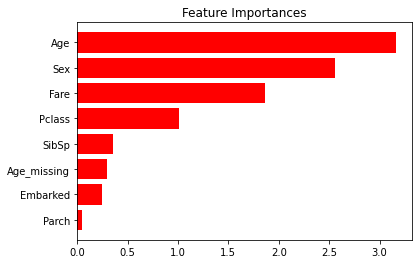

In [27]:
def get_feature_importances(model):
    if hasattr(model, 'feature_importances_'):
        return model.feature_importances_
    elif hasattr(model, 'coef_'):
        return np.abs(model.coef_.flatten())

def plot_feature_importances(model, feature_names=None, top_k=10, sort=True, **kwargs):
    feature_importances = get_feature_importances(model)
    idxs = feature_importances.argsort()[::-1] if sort else range(len(feature_importances))
    feature_names = np.range(len(feature_importances)) if feature_names is None else np.array(feature_names)
    feature_importances = feature_importances[idxs][:top_k]
    feature_names = feature_names[idxs][:top_k]
    plt.barh(feature_names[::-1], feature_importances[::-1], color='r', align='center')
    plt.title('Feature Importances')
    plt.show()
    
columns = df_baseline.drop(columns=['Survived']).columns
plot_feature_importances(lr_model_baseline, feature_names=columns, top_k=len(columns))

**Note:** In real life ML engineering, depending on business objectives and priorities, you might stop here and opt not to continue to feature engineer or improve the models. The reason is you often have a set of metrics thresholds indicating what's "good enough". Once you reach those thresholds, it often doesn't matter in a practical sense whether you can improve results. It's "good enough" and you can move onto other things. Odds are that all the feature engineering we're about to do will only improve the models by a percent or two (if even that), meaning you should really justify to yourself if the considerable extra development effort (both training and production) is worth it to you before doing so. It may make sense in research or in Kaggle where you're trying to hit a state of the art, but in most other cases other priorities are often as or more important than your model metrics. Think carefully.

## Data Cleaning and Feature Engineering: Second Pass

Let's now go back and see if we can improve results by feature engineering a little more. For one thing we have 3 columns we dropped and never attempted to use: `Name`, `Cabin`, and `Ticket`. Let's look at those in a little more detail.

Let's start with `Name` and look at a sample of the values. Printing the first 10 names we can see some patterns. First, names by and large tend to be in the order `last name, title, first name, middle name, alias`. Outside of that the strings don't appear to be that consistently formatted.

Since we're trying to predict survival, it also *might* be work printing out some examples of `Name` strings of those who survived vs those who didn't, and see if there's a pattern we can maybe exploit.

In [28]:
df['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [29]:
df['Name'][df['Survived'] == 1].head(10)

1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
15                     Hewlett, Mrs. (Mary D Kingcome) 
17                         Williams, Mr. Charles Eugene
19                              Masselmani, Mrs. Fatima
Name: Name, dtype: object

In [30]:
df['Name'][df['Survived'] == 0].head(10)

0                               Braund, Mr. Owen Harris
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
16                                 Rice, Master. Eugene
18    Vander Planke, Mrs. Julius (Emelia Maria Vande...
Name: Name, dtype: object

One pattern appears very clear in those who survived vs didn't: Those with titles like `Mr.` or `Master.` seem less likely to have survived than those with titles like `Mrs.` or `Miss.`. This is yet another reminder that survival on the Titanic strongly correlated with sex, something we already saw above in the baseline model. 

But, there may be something else to keeping these titles and making features out of them. So let's do that. I'm going to take the `Name` column and extract out of it a new column `Titles`. Let's first write some code to extract out the title for each column, and then show the value counts of those, so we can see which titles are worth keeping vs lumping together into a `Rare` group.

The way I'll extract titles is by using the regular expression ("regex") string `' ([A-Za-z]+)\.'`. If you're not familiar with regexes, this particular regex string says to take the input string from `Name`, match with any substring that
- doesn't come first in the input string,
- contains one or more alphabetical characters, possibly capitalized,
- ends in a period.

This makes sense for this particular problem of extracting titles because the titles aren't written first in the string, and always contain alphabetical characters followed by a period. After matching with substrings of this form, the regex will extract the alphabetical text *before* the period, and then show that (which we'll eventually dump into a new `Titles` column).

Looking at the value counts, we can see that the set of titles `Mr, Miss, Mrs, Master` all occur over 10 times in the dataset, and the rest look to be rare. We'll map all of these rare titles into their own `Rare` title class and keep the rest separately.

In [31]:
df['Name'].str.extract(' ([A-Za-z]+)\.').value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Mme           1
Ms            1
Capt          1
Lady          1
Jonkheer      1
Don           1
Countess      1
Sir           1
dtype: int64

In [32]:
titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Rare']
df['Titles'] = df['Name'].str.extract(' ([A-Za-z]+)\.')
df['Titles'] = df['Titles'].apply(lambda x: x if x in titles else 'Rare')
df['Titles'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Titles, dtype: int64

The last move will be to make `Titles` a good feature by mapping its values to integers and treating it as a categorical variable. After doing this, we will go ahead and drop the `Name` column, as other than the title there just doesn't seem to be much there that's left to extract in my opinion.

In [33]:
titles_dict = {title:idx for (idx,title) in enumerate(titles)}
df['Titles'] = df['Titles'].apply(lambda x: titles_dict[x])
df['Titles'].value_counts()

0    517
1    182
2    125
3     40
4     27
Name: Titles, dtype: int64

In [34]:
df = df.drop(columns='Name')
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_missing,Titles
0,0,3,0,0.271174,1,0,A/5 21171,0.760140,NaN,0,0,0
1,1,1,1,0.472229,1,0,PC 17599,0.888896,C85,1,0,2
2,1,3,1,0.321438,0,0,STON/O2. 3101282,0.765155,NaN,0,0,1
3,1,1,1,0.434531,1,0,113803,0.872307,C123,0,0,2
4,0,3,0,0.434531,0,0,373450,0.766037,NaN,0,0,0


The next column to attend to is `Ticket`. Let's again look at what these values tend to look like and see if there's a pattern. It looks like these are mostly strings of numbers. Some of them also have an alphanumeric prefix like `A/5` or `STON/02.`. Looking at the value counts, a small handful of ticket numbers are repeated, but the vast majority only have one count.

Looking at the numbers, it's difficult to say what they refer to. If they're like most ticket numbers today they're just arbitrary strings of numbers with no clear meaning. Maybe there's something to saving the prefixes though?

In [35]:
df['Ticket'].head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [36]:
df['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Focusing on the idea that the prefixes might have meaning, let's split off that part of the string and print out only the rows that have those prefixes (which I determine by checking if the string split contains at least 2 elements and dropping the rest). It looks like 226 of 891 passengers had a ticket with a prefix. Of those, it looks like 60 passengers had a `PC` prefix, 27 a `C.A.` prefix, etc.

In [37]:
ticket_prefixes = df['Ticket'].str.split().apply(lambda x: x[0] if len(x) >= 2 else None)
ticket_prefixes.value_counts()

PC            60
C.A.          27
STON/O        12
A/5           10
W./C.          9
CA.            8
SOTON/O.Q.     8
A/5.           7
SOTON/OQ       7
STON/O2.       6
CA             6
F.C.C.         5
C              5
SC/PARIS       5
S.O.C.         5
SC/Paris       4
A/4.           3
S.O./P.P.      3
SC/AH          3
PP             3
A/4            3
P/PP           2
S.C./PARIS     2
SOTON/O2       2
A.5.           2
WE/P           2
A./5.          2
A/S            1
SO/C           1
F.C.           1
S.W./PP        1
SW/PP          1
SC             1
SCO/W          1
W/C            1
Fa             1
S.O.P.         1
S.C./A.4.      1
A4.            1
S.P.           1
W.E.P.         1
C.A./SOTON     1
Name: Ticket, dtype: int64

The prefix strings do look a little messy. There are a lot of prefixes that are probably the same (e.g. `A/5`, `A/5.`, `A./5.`, and `A.5.`). It may help to clean these up by stripping out the punctuation, and then comparing.

This looks somewhat better. It looks like we have 6 values that occur at least 10 times. What I think I'll do is this: Create new category values for the top 6 most occuring prefixes, and map the rest to a new `Other` value. This will give us a new column with 7 categories. As most rows won't have a prefix, most of the time the value will be `Other`. But enough rows *do* have another value that there should be enough information in this column to use. This is *not* to say it'll do any good with improving the model, but it's something to try and see.

In [38]:
ticket_prefixes = ticket_prefixes.str.replace('/', '')
ticket_prefixes = ticket_prefixes.str.replace('.', '')
ticket_prefixes.value_counts()

PC         60
CA         41
A5         21
SOTONOQ    15
STONO      12
WC         10
SCPARIS     7
A4          7
STONO2      6
SOC         6
FCC         5
C           5
SCParis     4
WEP         3
SCAH        3
SOPP        3
PP          3
SOTONO2     2
SWPP        2
PPP         2
FC          1
AS          1
SCOW        1
SC          1
SP          1
Fa          1
SOP         1
SCA4        1
CASOTON     1
Name: Ticket, dtype: int64

In [39]:
prefixes = ['PC', 'CA', 'A5', 'SOTONOQ', 'STONO', 'WC', 'Other']
df['Prefix'] = ticket_prefixes.apply(lambda x: x if x in prefixes else 'Other')
df['Prefix'].value_counts()

Other      732
PC          60
CA          41
A5          21
SOTONOQ     15
STONO       12
WC          10
Name: Prefix, dtype: int64

Let's now map these new `Prefix` values to integers and treat them as a proper category. Note by the value counts this feature is highly imbalanced, so this may be kind of a crap shoot with improving performance.

In [40]:
prefix_dict = {prefix:idx for (idx,prefix) in enumerate(prefixes)}
df['Prefix'] = df['Prefix'].apply(lambda x: prefix_dict[x])
df['Prefix'].value_counts()

6    732
0     60
1     41
2     21
3     15
4     12
5     10
Name: Prefix, dtype: int64

In [41]:
df = df.drop(columns='Ticket')
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_missing,Titles,Prefix
0,0,3,0,0.271174,1,0,0.760140,NaN,0,0,0,2
1,1,1,1,0.472229,1,0,0.888896,C85,1,0,2,0
2,1,3,1,0.321438,0,0,0.765155,NaN,0,0,1,6
3,1,1,1,0.434531,1,0,0.872307,C123,0,0,2,6
4,0,3,0,0.434531,0,0,0.766037,NaN,0,0,0,6


Next is `Cabin`, which like `Name` and `Ticket` appears to be a high-dimensional categorical column, but unlike those it has lots of missing values. A full 77% of the data is missing! How should you impute this one? Let's step back and see if we can extract a feature here.

Printing the first few values, it looks like the cabin value is formatted letter-number, sometimes having multiple such values per passenger. Let's split these up by letter and number and see if we can spot a pattern in each separately.

In [42]:
df['Cabin'].dropna().head(10)

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object

In [43]:
df['Cabin'].value_counts(dropna=False)

NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

Below I look at some useful statistics that might be worth looking into for creating a feature here:
- From the printouts above it looks like some passengers have multiple cabin numbers. How frequent is this? If this is a fairly common thing, maybe we should create a feature tracking this.
- How often does each letter prefix in the cabin numbers appear? If they occur with enough frequency, it may be worth tracking them as a feature.
- How often does each number suffix in the cabin numbers appear? Again, if they occur enough, may be worth tracking.

Looking at these one by one. First, it looks like there are only 24 rows with multiple cabin numbers. That's like 2% of the data. Probably not worth keeping track of? This may be something to come back to later in model improvement iterations.

Second, looking at the value counts of the cabin prefix letters, they seem to take on 8 possible values, with most occuring with enough frequency that it may be worth tracking this.

Last, looking at the value counts of the cabin suffix numbers, there seem to be a lot of these, with none occuring at least 10 time. This suggest to me that this isn't worth keeping track of.

In [44]:
# number of rows with multiple cabins
df['Cabin'].str.split().dropna().apply(lambda x: len(x) > 1).sum()

24

In [45]:
df['Cabin'].str.split().dropna().apply(lambda x: x[0][0]).value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

In [46]:
df['Cabin'].str.split().dropna().apply(lambda x: x[0][1:] if x[0][1:] != '' else None).value_counts()

33     7
6      6
23     5
22     5
2      5
      ..
21     1
12     1
63     1
14     1
148    1
Name: Cabin, Length: 92, dtype: int64

Let's do this. We'll create a `Letter` feature that extracts and stores the cabin letter for each passenger. We'll keep `A, B, C, D, E, F` and map the rest to `Other`.

Since there are so many missing values, we need to deal with these as well. Since we can't drop them, I'll do the next simplest thing for now: I'll create a new `Letter_missing` feature to track which values are missing, and then impute the missing values in `Letter` with the mode `C`. This *does* risk grossly overweighting the importance of `C` relative to other letters, but hopefully the missing column combined with a model capable of learning complex correlations will help deal with this.

Finally, I'll convert these into proper categorical features by mapping them to integers, and then drop the `Cabin` column.

In [47]:
# using x[0][0] to account for possibility of multiple cabin numbers in a row, selecting first one arbitrarily
df['Letter'] = df['Cabin'].fillna(value='?').str.split().apply(lambda x: x[0][0])
df['Letter'] = df['Letter'].replace('?', np.nan)
df['Letter'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Letter, dtype: int64

In [48]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'Other']
df['Letter'] = df['Letter'].apply(lambda x: x if x in letters or pd.isna(x) else 'Other')
df['Letter'].value_counts()

C        59
B        47
D        33
E        32
A        15
F        13
Other     5
Name: Letter, dtype: int64

In [49]:
df['Letter_missing'] = df['Letter'].isna().astype(int)
df['Letter_missing'].value_counts()

1    687
0    204
Name: Letter_missing, dtype: int64

In [50]:
mode_letter = df['Letter'].mode().item()
df['Letter'] = df['Letter'].replace(np.nan, mode_letter)
df['Letter'].value_counts()

C        746
B         47
D         33
E         32
A         15
F         13
Other      5
Name: Letter, dtype: int64

In [51]:
letter_dict = {letter:idx for (idx,letter) in enumerate(letters)}
df['Letter'] = df['Letter'].apply(lambda x: letter_dict[x])
df['Letter'].value_counts()

2    746
1     47
3     33
4     32
0     15
5     13
6      5
Name: Letter, dtype: int64

In [52]:
df = df.drop(columns='Cabin')
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_missing,Titles,Prefix,Letter,Letter_missing
0,0,3,0,0.271174,1,0,0.760140,0,0,0,2,2,1
1,1,1,1,0.472229,1,0,0.888896,1,0,2,0,2,0
2,1,3,1,0.321438,0,0,0.765155,0,0,1,6,2,1
3,1,1,1,0.434531,1,0,0.872307,0,0,2,6,2,0
4,0,3,0,0.434531,0,0,0.766037,0,0,0,6,2,1


## Model Training

Now we're good to go. We've feature engineered all of our original input columns. We have an array of numerical data that we can do machine learning with.

Let's start by looking at what happens if we train a model with the new features, but don't do any one-hot encoding of the categorical features.

Looks like we're already doing pretty good. The F1 scores for both RF and LR have pulled up a few percent. Can we do still better by one-hot encoding, or by balancing the data?

In [53]:
X_no_onehot = df.copy().drop(columns='Survived').values
X_no_onehot.shape

(891, 12)

In [54]:
X_train_no_onehot = X_no_onehot[idx_train]
X_test_no_onehot = X_no_onehot[idx_test]

In [55]:
rf_model_no_onehot = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced')
rf_model_no_onehot.fit(X_train_no_onehot, y_train)

yhat = rf_model_no_onehot.predict(X_test_no_onehot)
get_scores(y_test, yhat)

accuracy:  0.838
precision:  0.7571
recall:  0.8154
f1:  0.7852
auc:  0.8331
confusion matrix:
 [[97 17]
 [12 53]]


In [56]:
lr_model_no_onehot = LogisticRegressionCV(random_state=seed, class_weight='balanced')
lr_model_no_onehot.fit(X_train_no_onehot, y_train)

yhat = lr_model_no_onehot.predict(X_test_no_onehot)
get_scores(y_test, yhat)

accuracy:  0.8156
precision:  0.7051
recall:  0.8462
f1:  0.7692
auc:  0.8222
confusion matrix:
 [[91 23]
 [10 55]]


Let's now instead treat the categorical features as we "should", by one-hot encoding them first. Recall that one-hot encoding is a way of converting one feature of k categories `A1, A2, ..., Ak` into k features of 2 categories `is_A1, is_A2, ..., is_A3`. Essentially it creates a series of binary indicator that looks for whether a particular category is present, each being its own feature.

I'll only one-hot encode the features we'd already decided were categorical, and that contain more than 2 categories. Note that if a feature only contains 2 categories you don't need to one-hot encode it. Why?

We can easily one-hot encode features by using the `pd.get_dummies` function, passing in the columns that we want to one-hot encode, i.e. the categorical columns with more than 2 categories.

In [57]:
df_one_hot = pd.get_dummies(df, columns=['Pclass', 'Embarked', 'Titles', 'Prefix', 'Letter'])
df_one_hot.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Age_missing,Letter_missing,Pclass_1,Pclass_2,...,Prefix_4,Prefix_5,Prefix_6,Letter_0,Letter_1,Letter_2,Letter_3,Letter_4,Letter_5,Letter_6
0,0,0,0.271174,1,0,0.760140,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0.472229,1,0,0.888896,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0.321438,0,0,0.765155,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,1,0.434531,1,0,0.872307,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
4,0,0,0.434531,0,0,0.766037,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [58]:
X_onehot = df_one_hot.copy().drop(columns='Survived').values
X_onehot.shape

(891, 32)

In [59]:
X_train_onehot = X_onehot[idx_train]
X_test_onehot = X_onehot[idx_test]

Training an RF and LR now, it looks like performance is slightly better or about the same as without the one-hot encodings.

In [60]:
rf_model_onehot = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced')
rf_model_onehot.fit(X_train_onehot, y_train)

yhat = rf_model_onehot.predict(X_test_onehot)
get_scores(y_test, yhat)

accuracy:  0.8436
precision:  0.7681
recall:  0.8154
f1:  0.791
auc:  0.8375
confusion matrix:
 [[98 16]
 [12 53]]


In [61]:
lr_model_onehot = LogisticRegressionCV(random_state=seed, class_weight='balanced')
lr_model_onehot.fit(X_train_onehot, y_train)

yhat = lr_model_onehot.predict(X_test_onehot)
get_scores(y_test, yhat)

accuracy:  0.8603
precision:  0.7703
recall:  0.8769
f1:  0.8201
auc:  0.8639
confusion matrix:
 [[97 17]
 [ 8 57]]


Before moving on, let's look at the logistic regression model's feature importances again to see if anything is different now. It looks like `Age`, `Fare`, and `Sex` are still important features, but some of the new one-hot features snuck in too. The top handful of new features appear to be `Prefix_4` (i.e. tickets with a `STON/O` prefix), `Title_3` (people title "Master", i.e. young boys), and `Title_0` (people title "Mr", i.e. older men). Since these two title features clearly correlate with `Sex` and `Age`, they're likely diminishing the true importance of the `Sex` `Age ` features as predictors of survival.

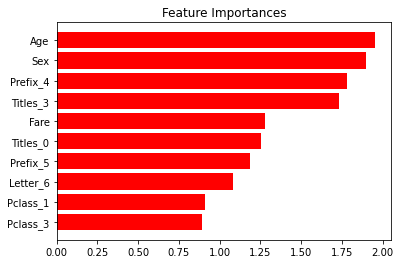

In [62]:
columns = df_one_hot.copy().drop(columns='Survived').columns
plot_feature_importances(lr_model_onehot, columns, top_k=10)

Since we'll need our cleaned data in the next tutorial, we'll want to go ahead and save it for future use. We can do this using the pandas dataframe `to_csv` method, specifying the path where we want it to save. Note the use of the `pathlib.Path` object for specifying file paths. This is by far the most convenient way to work with paths in modern versions of python. The path we'll save to is `../resources/titanic_cleaned.csv`.

In [63]:
path = Path().cwd().parent / 'resources'
df_one_hot.to_csv(path / 'titanic_cleaned.csv')

## Summary

Since we've calculated a lot of scores on several different models, it's not a bad idea to put them all into a table so we can compare them against each other. We'll do that in the table below, which is set up to auto fill in the scores from above (even if we run it with a different seed). Cool, right? 

**Note:** Unfortunately, this table won't render correctly if you're viewing it from Github or an online notebook viewer, as it requires that extensions be installed. To view it correctly, you'll need to download the notebook and run it locally, after installing the Jupyter [contrib extensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html) and enabling the python in markdown extension.

|(seed={{seed}})|accuracy|precision|recall|F1|AUC|
|---|---|---|---|---|---|
|RF baseline|{{round(accuracy_score(y_test, rf_model_baseline.predict(X_test_baseline)),4)}}|{{round(precision_score(y_test, rf_model_baseline.predict(X_test_baseline)),4)}}|{{round(recall_score(y_test, rf_model_baseline.predict(X_test_baseline)),4)}}|{{round(f1_score(y_test, rf_model_baseline.predict(X_test_baseline)),4)}}|{{round(roc_auc_score(y_test, rf_model_baseline.predict(X_test_baseline)),4)}}|{{round(recall_score(y_test, rf_model_baseline.predict(X_test_baseline)),4)}}|
|LR baseline|{{round(accuracy_score(y_test, lr_model_baseline.predict(X_test_baseline)),4)}}|{{round(precision_score(y_test, lr_model_baseline.predict(X_test_baseline)),4)}}|{{round(recall_score(y_test, lr_model_baseline.predict(X_test_baseline)),4)}}|{{round(f1_score(y_test, lr_model_baseline.predict(X_test_baseline)),4)}}|{{round(roc_auc_score(y_test, lr_model_baseline.predict(X_test_baseline)),4)}}|
|RF no onehot|{{round(accuracy_score(y_test, rf_model_no_onehot.predict(X_test_no_onehot)),4)}}|{{round(precision_score(y_test, rf_model_no_onehot.predict(X_test_no_onehot)),4)}}|{{round(recall_score(y_test, rf_model_no_onehot.predict(X_test_no_onehot)),4)}}|{{round(f1_score(y_test, rf_model_no_onehot.predict(X_test_no_onehot)),4)}}|{{round(roc_auc_score(y_test, rf_model_no_onehot.predict(X_test_no_onehot)),4)}}|
|LR no onehot|{{round(accuracy_score(y_test, lr_model_no_onehot.predict(X_test_no_onehot)),4)}}|{{round(precision_score(y_test, lr_model_no_onehot.predict(X_test_no_onehot)),4)}}|{{round(recall_score(y_test, lr_model_no_onehot.predict(X_test_no_onehot)),4)}}|{{round(f1_score(y_test, lr_model_no_onehot.predict(X_test_no_onehot)),4)}}|{{round(roc_auc_score(y_test, lr_model_no_onehot.predict(X_test_no_onehot)),4)}}|
|RF onehot|{{round(accuracy_score(y_test, rf_model_onehot.predict(X_test_onehot)),4)}}|{{round(precision_score(y_test, rf_model_onehot.predict(X_test_onehot)),4)}}|{{round(recall_score(y_test, rf_model_onehot.predict(X_test_onehot)),4)}}|{{round(f1_score(y_test, rf_model_onehot.predict(X_test_onehot)),4)}}|{{round(roc_auc_score(y_test, rf_model_onehot.predict(X_test_onehot)),4)}}|
|LR onehot|{{round(accuracy_score(y_test, lr_model_onehot.predict(X_test_onehot)),4)}}|{{round(precision_score(y_test, lr_model_onehot.predict(X_test_onehot)),4)}}|{{round(recall_score(y_test, lr_model_onehot.predict(X_test_onehot)),4)}}|{{round(f1_score(y_test, lr_model_onehot.predict(X_test_onehot)),4)}}|{{round(roc_auc_score(y_test, lr_model_onehot.predict(X_test_onehot)),4)}}|

It looks like the LR onehot model is on the whole doing the best across all metrics. This suggests we should choose this model, right? Well, perhaps not. It turns out that the above scores are *very* sensitive to the choice of seed. I deliberately picked a seed (123) that gives "high" accuracies of 85-86%. Most other seeds will actually give lower accuracies, sometimes 77-82%. Try changing the seed at the top of the notebook to 42 and re-running if you don't believe me!

Given that our metrics have uncertainties on the order of 2-5% depending which seed we choose, how do we know which model is truly "best"? After all, in ML we usually want a model that works best on *all unseen* data, not particular "lucky" subsets of the data. The reason we're having this problem is because our dataset is "small". That may seem surprising, given that it has 891 examples, but *relative to the task* it's quite small. Predicting survival from this dataset turns out to be a surprisingly noisy task, which means to get stable, accurate estimates we'd need a lot more data.

What can we do about this problem, given that we can't exactly get more Titanic data? The trick is to use model selection techniques like K-fold cross validation. These techniques will allow us to work better with small-ish, noisy data like Titanic. 

In the next tutorial, we'll use model selection techniques to help pick out the best model to use. We'll also talk a little bit about so-called ML Ops and how to deploy a simple Titanic survival prediction model to "production".